Monte Carlo integration is an extremely powerful method for evaluating high-dimensional integrals. It's a method that, I find, is not nearly as well known as it should be. This post is an attempt at fixing this.

The post was originally written as an [IPython notebook](http://ipython.org/notebook.html) which you can download [here](nbs/mc_integration.ipynb).

In [4]:
from __future__ import print_function

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import numpy as np
#import seaborn as sns

In [2]:

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 
tableau20 = [ (r/255.,g/255.,b/255.) for (r,g,b) in tableau20 ]

rcParams["lines.linewidth"] = 2
#rcParams["lines.color"] = cm.Blues(1.0)
rcParams["text.usetex"] = True
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = "Computer Modern sans serif"
rcParams["mathtext.fontset"] = "custom"
rcParams["mathtext.default"] = "regular"
#rcParams["font]
rcParams["font.size"] = 18

#sns.set_style("whitegrid")
#sns.set_context("notebook", font_scale=1.5)

## Traditional integration methods

We want to integrate a function $f(x) = x^2$ in the domain $0 < x \le 3$.
Intuitively, we can model the function as lots of small rectangles stacked vertically next
to each other, and sum the area of each rectangle. If we decrease the width of
each rectangle, we will eventually tend to the correct answer.

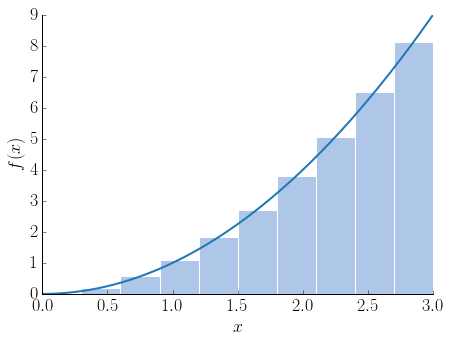

In [22]:
plt.figure(figsize=(7,5))
x = np.linspace(0.,3.,200)
plt.plot(x, x**2, color=tableau20[0])

rectangle_width = 0.3
nrectangles = int(round(3./rectangle_width))

for irectangle in range(nrectangles):
    left = irectangle*rectangle_width
    right = (irectangle+1)*rectangle_width
    mid_point = (left + right)/2.
    plt.fill_between([left, right], [mid_point**2, mid_point**2], facecolor=tableau20[1],edgecolor=(1.,1.,1.))
    
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()

This is the basic premise behind most traditional methods of integration. Setting this out mathematically, we approximate the integral $\int_a^b f(x) \; \mathrm{d}x$ as the sum of the area of $N$ rectangles. If the area of the $i$-th rectangle from the left (from $a$) is $A_i$, we can then write this approximation as,

$$\int_a^b f(x) \; \mathrm{d}x \simeq \sum_i^N A_i \; .$$

If we denote the mid-point of each rectangle as $x_i$, then the height of the $i$-th rectangle will be $f(x_i)$. The width of all the rectangles is identical: $\frac{b-a}{N}$. The area $A_i$ is therefore 

$$A_i = f(x_i) \times \frac{b-a}{N} \; .$$

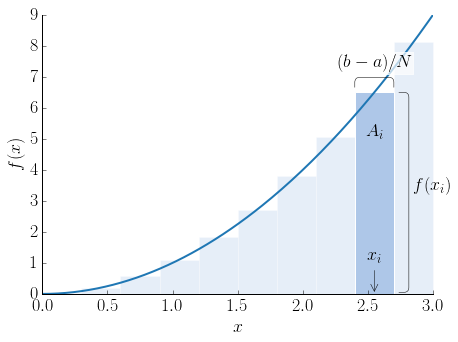

In [21]:
f = plt.figure(figsize=(7,5))
x = np.linspace(0.,3.,200)
ax0 = f.gca()
ax0.plot(x, x**2, color=tableau20[0])

rectangle_width = 0.3
nrectangles = int(round(3./rectangle_width))

key_rect = nrectangles-2

for irectangle in range(nrectangles):
    if irectangle != key_rect:
        left = irectangle*rectangle_width
        right = (irectangle+1)*rectangle_width
        mid_point = (left + right)/2.
        ax0.fill_between([left, right], [mid_point**2, mid_point**2], facecolor=tableau20[1],edgecolor=(1.,1.,1.),alpha=0.3)
        
# Plotting key rectangle
left = key_rect*rectangle_width
right = (key_rect+1)*rectangle_width
mid_point = (left + right)/2.
ax0.fill_between([left, right], [mid_point**2, mid_point**2], facecolor=tableau20[1], edgecolor=(1.,1.,1.))


ax0.annotate("$x_i$",xy=(mid_point,0.), xytext=(mid_point, 1.), ha="center",arrowprops={"arrowstyle":"->","linewidth":0.5})

arrow_kwargs = {'arrowprops':dict(arrowstyle="-",
                            connectionstyle="arc,angleA=0,angleB=0,armA=15,armB=15,rad=5",
                            ec="k",
                            shrinkA=5, shrinkB=5,
                            linewidth=0.5
                            )}

ax0.annotate('', xy=(right, 0.05),
                        xytext=(right, mid_point**2),
                        **arrow_kwargs)
ax0.annotate("$f(x_i)$", xy=(right+0.15, 0.5*mid_point**2))

arrow_kwargs = {'arrowprops':dict(arrowstyle="-",
                            connectionstyle="arc,angleA=90,angleB=90,armA=15,armB=15,rad=5",
                            ec="k",
                            shrinkA=5, shrinkB=5,
                            linewidth=0.5
                            )}
ax0.annotate('', xy=(left, mid_point**2), xytext=(right, mid_point**2),**arrow_kwargs)
ax0.annotate("$(b-a)/N$", xy=(mid_point, mid_point**2+0.8),ha="center",backgroundcolor=(1.,1.,1.,0.7))

ax0.annotate("$A_i$", xy=(mid_point,5.),ha="center")

ax0.set_xlabel("$x$")
ax0.set_ylabel("$f(x)$")
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.get_xaxis().tick_bottom()
ax0.get_yaxis().tick_left()

Let's code this up in Python for the function $f(x) = x^2$ between 0 and 3. We will use 100 rectangles.

In [45]:
import numpy as np

nrectangles = 100 # number of x-values to use to calculate the average.

# Integration domain
xlow = 0.
xhigh = 3.

# Integrand
f = lambda x: x**2

xvalues = np.linspace(xlow, xhigh, nrectangles)
fvalues = f(xvalues) # f(x_i) for each rectangle
areas = fvalues * (xhigh - xlow)/nrectangles # A_i for each rectangle
integral = sum(areas)

print("Integral: ", integral)

Integral:  9.04545454545


These values are a little off the correct ones (the correct value is 9). Increasing the number of points would lead to an improved estimate.

## Monte Carlo integration

Monte Carlo integration works in a similar manner, but, instead of distributing the rectangles uniformly in the integration domain, we distribute them randomly. Let's see this in action. 

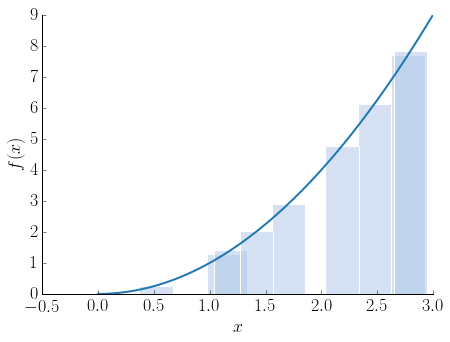

In [34]:
plt.figure(figsize=(7,5))
xlow, xhigh = 0., 3.
npoints = 10
plt.plot(x, x**2, color=tableau20[0])
xvalues = xlow + (xhigh-xlow)*np.random.random(npoints)
rectangle_width = 0.3
nrectangles = int(round((xhigh-xlow)/rectangle_width))

for irectangle in range(nrectangles):
    mid_point = xvalues[irectangle]
    left = mid_point-rectangle_width/2.
    right = mid_point+rectangle_width/2.
    plt.fill_between([left, right], [mid_point**2, mid_point**2], facecolor=(174/255., 199/255., 232/255.,0.5),edgecolor=(1.,1.,1.))
    
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()

As you can see, some of the rectangles overlap, and parts of the data range are not covered by rectangles. It's not even terribly clear that this gives the right answer, but you can show, with a [bit of maths](http://en.wikipedia.org/wiki/Central_limit_theorem), that the more rectangles you use, the closer you get to the right answer. Let's code this in Python. As before, we will calculate $\int_0^3 x^2 \; \mathrm{d}x$.

In [47]:
# Number of rectangles
nrectangles = 100

# Integrand
f = lambda x: x**2

# Integration domain
xlow = 0.
xhigh = 3.

# randomly distributed rectangle mid-points
xvalues = xlow + (xhigh-xlow)*np.random.random(nrectangles) 
fvalues = f(xvalues) # f(x_i) for each rectangle
areas = fvalues * (xhigh-xlow)/nrectangles # Area for each rectangle

integral = sum(areas)
print("Integral: ", integral)

Integral:  8.93542385496


Note that if you are running this yourself, you might get very different answers (we are using random numbers, after all). Increasing the number of points leads to estimates of the integral that converge to 9, as expected.

## Monte Carlo integration in Python

There is a Python module for Monte Carlo integration, called [scikit-monaco](https://pypi.python.org/pypi/scikit-monaco). There are instructions on the [website](http://scikit-monaco.readthedocs.org/en/latest/) on how to install it if you don't have it yet. For example, to calulate the integral of $f(x) = x^2$ over the domain $0 < x \le 3$:

In [50]:
from skmonaco import mcquad
nrectangles = 1e5
value, error = mcquad(lambda x: float(x**2), nrectangles, [xlow], [xhigh])
print("{} +/- {}".format(value, error))

8.99218977184 +/- 0.0254341400804


## Why Monte Carlo integration?

If you have read this far, you might have noticed that using Monte Carlo integration gives a
less accurate result than grid-based method, for the same number of points. So
why is Monte Carlo integration useful?

For a given computational cost, traditional methods perform very badly if you
increase the number of dimensions. So far, we have only been integrating a function
of one variable. Let's now imagine that we have a function of $N$ variables, where $N$ is an integer. I will call
these variables $x_1, x_2, \ldots x_N$. We now want to integrate the function $f(x_1, x_2, \ldots x_N) = x_1^2 + x_2^2 + \ldots + x_N^2$ over the domain $0< x_1 \le 1,\; 0 < x_2 \le 1,\; \ldots 0 < x_N \le 1$.

Let's look at an example with $N = 3$. The function is 

$$f(x_1, x_2, x_3) = x_1^2 + x_2^2 + x_3^2 = \sum_{i=1}^3 x_i^2$$

We can represent this function in Python:

In [5]:
f = lambda xs : sum(xs**2)

# Let's evaluate f at x_1 = 0.2, x_2 = 0.3, x_3 = 0.4:
f(np.array([0.2, 0.3, 0.4])) 

0.29000000000000004

We want to compare how grid-based methods compare to Monte Carlo methods as we increase the number of dimensions. To have a consistent metric, we will assume we have a budget of $2^{18} = 262144$ function evalutations (I chose this number because it divides nicely into different powers of two, which makes generating a grid quite a lot easier). We will compare the accuracy of the prediction after this many evaluations. Download the attached [IPython notebook](nbs/mc_integration.ipynb) to see the code used for generating the grid.

In [10]:
import itertools

xlow = 0.
xhigh = 1.
npoints = 2**18

def integrate_analytical(ndimensions): 
    return ndimensions * (1./3.)

def integrate_grid(ndimensions):
    """
    Integrate f by calculating the average value of a set of 
    points distributed on an `ndimensional` grid in the
    integration domain.
    """
    assert ndimensions in (1,2,3,6,9,18),\
        "Number of dimensions must be a divisor of 18."
    npoints_per_dimension = 2**(18//ndimensions)
    dx = (xhigh-xlow)/float(npoints_per_dimension) # spacing between points along each dimension
    coordinates = np.linspace(xlow+dx/2., xhigh-dx/2., npoints_per_dimension) 
    # array of coordinates along each direction. Eg. if "npoints_per_dimension" is 4,
    # coordinates is array([ 0.375,  1.125,  1.875,  2.625])
    
    # "points" is a list of points. For instance, if "npoints_per_dimension" is 4 
    # and "ndimensions" is 9, "points" is:
    # [ [ 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375],
    #   [ 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 1.125],
    #   [ 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 1.875],
    #   ...
    #   [ 2.625,  2.625,  2.625,  2.625,  2.625,  2.625,  2.625,  2.625]]
    points = np.array(list(itertools.product(coordinates, repeat=ndimensions)))
    
    # Evaluate "f" at each point.
    fvalues = [ f(point) for point in points ]
    
    averagef = sum(fvalues) / npoints # Average value of "f" in the domain of integration
    
    # Calculate the integral from the average by multiplying it by the integration volume
    integration_volume = (xhigh-xlow)**ndimensions
    integral = averagef * integration_volume
    return integral

def relative_error_grid(ndimensions):
    estimate = integrate_grid(ndimensions)
    true_value = integrate_analytical(ndimensions)
    return abs(estimate - true_value) / true_value

def relative_error_mc(ndimensions): 
    estimate, absolute_error = mcquad(f, npoints, [xlow]*ndimensions, [xhigh]*ndimensions)
    return absolute_error/estimate

In [11]:
ndimensions = [ 1, 2, 3, 6, 9, 18 ]
grid_errors = [ relative_error_grid(n) for n in ndimensions ]
mc_errors = [ relative_error_mc(n) for n in ndimensions ]

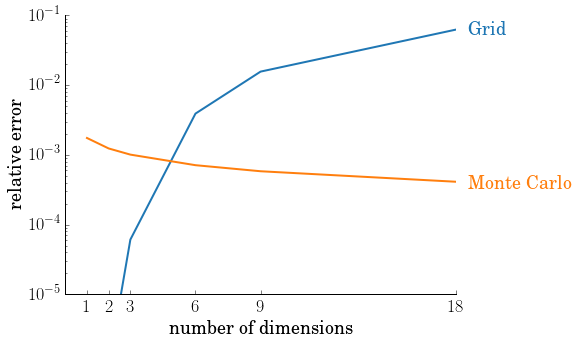

In [16]:
plt.figure(figsize=(7,5))
plt.yscale("log")
plt.plot(ndimensions, grid_errors, color=tableau20[0])
plt.plot(ndimensions, mc_errors, color=tableau20[2])
plt.ylim(1e-5,1e-1)
plt.xticks([1,2,3,6,9,18])

plt.annotate("Monte Carlo", xy=(1.03,0.38), xycoords="axes fraction", color=tableau20[2])
plt.annotate("Grid", xy=(1.03,0.93), xycoords="axes fraction", color=tableau20[0])

plt.xlabel("number of dimensions")
plt.ylabel("relative error")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()

As the plot shows, the relative error in a Monte Carlo integration remains approximately the same as you increase the number of dimensions (it even decreases a little for this particular function). In contrast, the relative error of the grid-based method starts low, but increases exponentially with the number of dimensions.

For this particular problem, the two methods cross over around $d = 4.5$. So for a problem with more than about five dimensions, Monte Carlo integration gives significantly better results for the same computational effort. Using a better grid-based integration method would improve the scaling slightly, but the exponential decrease in accuracy remains.

## Conclusion

Monte Carlo integration performs much better for high-dimensional integrals. It's not uncommon to see Monte Carlo integration used on problems with several hundreds of dimensions. Monte Carlo integration is used, in various forms, as part of [Markov Chain Monte Carlo](en.wikipedia.org/wiki/Markov_chain_Monte_Carlo), a practical method of doing Bayesian statistical analysis, or [quantum Monte Carlo](http://en.wikipedia.org/wiki/Quantum_Monte_Carlo), a set of methods for integrating the Schr&#246;dinger equation to predict the behaviour of quantum particles.